In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x/255.0, test_x/255.0

In [3]:
train_x.shape

(60000, 28, 28)

In [4]:
train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [53]:
#input layer
input_h = 28   # input height
input_w = 28   # input width
input_ch = 1   # input channel : Gray scale


# 1st convolution layer
k1_h = 3
k1_w = 3
k1_ch = 32
p1_h = 2
p1_w = 2
# (None, 14, 14, 32)

# 2nd convolution layer
k2_h = 3
k2_w = 3
k2_ch = 64
p2_h = 2
p2_w = 2
# (None, 7, 7, 64)

# Fully connected : flatten the features (7x7x64)
conv_result_size = 4 * 4 * 64  
n_hidden = 100
n_output = 10

In [55]:
# Kernel size : [kernel_height, kernel_width, input_ch, output_ch]
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

weights = {
    'conv1' : tf.Variable(tf.random.normal([k1_h, k1_w, input_ch, k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random.normal([k2_h, k2_w, k1_ch, k2_ch], stddev = 0.1)),
    'hidden' : tf.Variable(tf.random.normal([1024, 100])),
    'output' : tf.Variable(tf.random.normal([n_hidden, n_output], stddev = 0.1))
}

# bias size : [output_ch] or [neuron_size]
biases = {
    'conv1' : tf.Variable(tf.random.normal([k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random.normal([k2_ch], stddev = 0.1)),
    'hidden' : tf.Variable(tf.random.normal([n_hidden], stddev = 0.1)),
    'output' : tf.Variable(tf.random.normal([n_output], stddev = 0.1))
}

# input layer : [batch_size, image_height, image_width, channels]
# output layer : [batch_size, class_size]
x = tf.placeholder(shape=[None, input_h, input_w, input_ch], dtype=tf.float32)
y = tf.placeholder(shape=[None, n_output], dtype=tf.float32)

In [57]:
# [batch, height, width, channels]

def net(x, weights, biases):
    # 1st convolution layer
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides = [1,1,1,1], padding = 'SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool(conv1 , ksize = [1, k1_h, k1_w , 1], strides = [1, k1_h, k1_w, 1], padding = 'SAME')
#   maxp1 = tf.nn.max_pool(conv1, ksize=[1,p1_h,p1_w,1], strides=[1,p1_h,p1_w,1], padding='VALID')

    # 2nd convolution layer
    conv2 = tf.nn.conv2d(maxp1, weights['conv2'], strides = [1,1,1,1], padding = 'SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool(conv2 , ksize = [1, k2_h, k2_w, 1], strides = [1, k2_h, k2_w, 1], padding = 'SAME')

    shape = maxp2.get_shape().as_list()
    if None in shape:
        shape = tf.shape(maxp2)
        flatten_dim = shape[1] * shape[2] * shape[3]
        maxp2_flatten = tf.reshape(maxp2, [tf.shape(maxp2)[0], flatten_dim])
    else:
        flatten_dim = shape[1] * shape[2] * shape[3]
        maxp2_flatten = tf.reshape(maxp2, [-1, flatten_dim])

    # Fully connected
    hidden = tf.add(tf.matmul(maxp2_flatten, weights['hidden']), biases['hidden'])
    hidden = tf.nn.relu(hidden)
    output = tf.add(tf.matmul(hidden, weights['output']), biases['output'])

    return output

In [63]:
LR = 0.0001

# 모델 예측값 (logits)
pred = net(x, weights, biases)  # x, weights, biases는 앞에서 정의된 값

# 손실 함수 (softmax + cross entropy)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y)
loss = tf.reduce_mean(loss)

# 최적화 함수 (Adam Optimizer)
optm = tf.train.AdamOptimizer(learning_rate=LR).minimize(loss)

Iter : 0
Train Loss : 4.0644755363464355
Cost : 4.603369235992432
Iter : 250
Train Loss : 0.9685379862785339
Cost : 1.2212532758712769
Iter : 500
Train Loss : 0.36694857478141785
Cost : 0.5131388902664185
Iter : 750
Train Loss : 0.3096661865711212
Cost : 0.2714218199253082
Iter : 1000
Train Loss : 0.23600979149341583
Cost : 0.2533071041107178
Iter : 1250
Train Loss : 0.2193620502948761
Cost : 0.3497775197029114
Iter : 1500
Train Loss : 0.1825941801071167
Cost : 0.6121371984481812
Iter : 1750
Train Loss : 0.16372562944889069
Cost : 0.08277502655982971
Iter : 2000
Train Loss : 0.14533855020999908
Cost : 0.10488278418779373
Iter : 2250
Train Loss : 0.2140807956457138
Cost : 0.2592143416404724


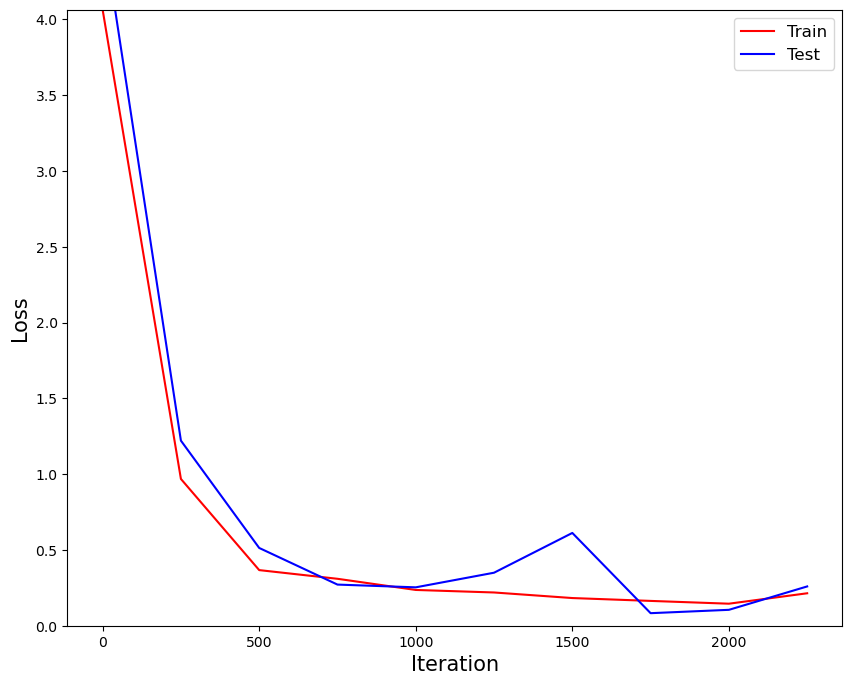

In [65]:
# Optimization

n_batch = 50
n_iter = 2500
n_prt = 250

sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_record_train = []
loss_record_test = []
for epoch in range(n_iter):
    # train_x, train_y = mnist.train.next_batch(n_batch)
    # train_x = np.reshape(train_x, (-1, 28, 28, 1))
    # # train_x = np.reshape(train_x, (n_batch, input_h, input_w, input_ch))
    # sess.run(optm, feed_dict={x:train_x, y:train_y})

    # Get a random batch of training data
    batch_indices = np.random.choice(train_x.shape[0], size=n_batch, replace=False)
    batch_x = train_x[batch_indices]
    batch_y = train_y[batch_indices]

    batch_x = np.reshape(batch_x, (-1, 28, 28, 1))
    # batch_x = np.reshape(batch_x, (n_batch, input_h, input_w, input_ch))
    # Convert labels to one-hot encoding if necessary
    batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=10)  # Adjust num_classes if needed

    sess.run(optm, feed_dict={x:batch_x, y:batch_y})

    if epoch % n_prt == 0:
        # test_x, test_y = mnist.test.next_batch(n_batch)
        # test_x = test_x.reshape((n_batch, input_h, input_w, input_ch))
        # c1 = sess.run(loss, feed_dict={x:train_x, y:train_y})
        # c2 = sess.run(loss, feed_dict={x:test_x, y:test_y})

        # Get a random batch of test data
        test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
        test_batch_x = test_x[test_batch_indices]
        test_batch_y = test_y[test_batch_indices]

        test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
        # Convert labels to one-hot encoding if necessary
        test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)  # Adjust num_classes if needed
        c1 = sess.run(loss, feed_dict={x: batch_x, y: batch_y})
        c2 = sess.run(loss, feed_dict={x: test_batch_x, y: test_batch_y})

        loss_record_train.append(c1)
        loss_record_test.append(c2)
        print("Iter : {}".format(epoch))
        print("Train Loss : {}".format(c1))
        print("Cost : {}".format(c2))

plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, 'r', label = 'Train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, 'b', label = 'Test')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

In [67]:
# Evaluation
# Get a random batch of test data
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))  # Reshape the batch if needed
# Convert labels to one-hot encoding if necessary
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)  # Adjust num_classes if needed

my_pred = sess.run(pred, feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
my_pred = np.argmax(my_pred, axis=1)

labels = np.argmax(test_batch_y, axis=1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}".format(accr*100))

Accuracy : 100.0


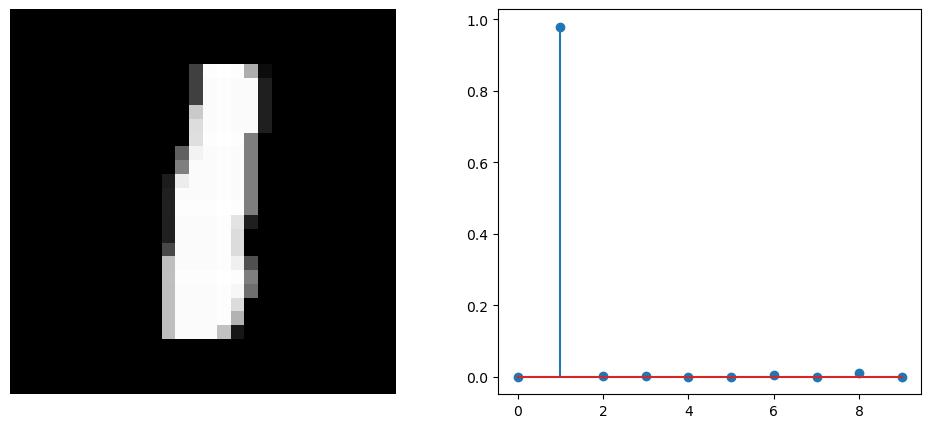

Prediction : 1
Probability : [0.   0.98 0.   0.   0.   0.   0.01 0.   0.01 0.  ]


In [69]:
# Get a random batch of test data
n_batch = 1
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))  # Reshape the batch if needed
# Convert labels to one-hot encoding if necessary
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)  # Adjust num_classes if needed

logits = sess.run(tf.nn.softmax(pred), feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
predict = np.argmax(logits)

plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.imshow(test_batch_x.reshape(28, 28), 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.stem(logits.ravel())
plt.show()

np.set_printoptions(precision = 2, suppress = True)
print('Prediction : {}'.format(predict))
print('Probability : {}'.format(logits.ravel()))

In [79]:
#input layer
input_h, input_w, input_ch = 28, 28, 1
n_hidden = 625
n_output = 10
LR = 0.0001

# 1st convolution layer
k1_h = 3
k1_w = 3
k1_ch = 32
p1_h = 2
p1_w = 2
# (None, 14, 14, 32)

# 2nd convolution layer
k2_h = 3
k2_w = 3
k2_ch = 64
p2_h = 2
p2_w = 2
# (None, 7, 7, 64)

# Fully connected : flatten the features (7x7x64)
conv_result_size = 4 * 4 * 64  
n_hidden = 100
n_output = 10

In [81]:
# Kernel size : [kernel_height, kernel_width, input_ch, output_ch]
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

weights = {
    'conv1': tf.Variable(tf.random.normal([3, 3, 1, 32], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([3, 3, 32, 64], stddev=0.1)),
    'conv3': tf.Variable(tf.random.normal([3, 3, 64, 128], stddev=0.1)),
    'fc1': tf.Variable(tf.random.normal([4 * 4 * 128, 625], stddev=0.1)),
    'fc2': tf.Variable(tf.random.normal([625, 10], stddev=0.1))
}
biases = {
    'conv1': tf.Variable(tf.random.normal([32], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([64], stddev=0.1)),
    'conv3': tf.Variable(tf.random.normal([128], stddev=0.1)),
    'fc1': tf.Variable(tf.random.normal([625], stddev=0.1)),
    'fc2': tf.Variable(tf.random.normal([10], stddev=0.1))
}


# input layer : [batch_size, image_height, image_width, channels]
# output layer : [batch_size, class_size]
x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, n_output])


In [83]:
# [batch, height, width, channels]

def net(x, weights, biases):
    conv1 = tf.nn.relu(tf.nn.conv2d(x, weights['conv1'], [1, 1, 1, 1], 'SAME') + biases['conv1'])
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')

    conv2 = tf.nn.relu(tf.nn.conv2d(pool1, weights['conv2'], [1, 1, 1, 1], 'SAME') + biases['conv2'])
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')

    conv3 = tf.nn.relu(tf.nn.conv2d(pool2, weights['conv3'], [1, 1, 1, 1], 'SAME') + biases['conv3'])
    pool3 = tf.nn.max_pool(conv3, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')

    flat = tf.reshape(pool3, [-1, 4 * 4 * 128])
    fc1 = tf.nn.relu(tf.matmul(flat, weights['fc1']) + biases['fc1'])
    output = tf.matmul(fc1, weights['fc2']) + biases['fc2']
    return output

In [93]:
LR = 0.0001

# 모델 예측값 (logits)
logits = net(x, weights, biases)

# 손실 함수
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

# 최적화
optm = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

# ✅ 정확도 정의 (이거 꼭 있어야 함!)
correct = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

[0] Train Loss: 4.2223, Acc: 0.1400 | Test Loss: 3.9440, Acc: 0.1200
[250] Train Loss: 0.0046, Acc: 1.0000 | Test Loss: 1.0228, Acc: 0.7000
[500] Train Loss: 0.0005, Acc: 1.0000 | Test Loss: 1.0440, Acc: 0.6800
[750] Train Loss: 0.0001, Acc: 1.0000 | Test Loss: 1.0813, Acc: 0.7000
[1000] Train Loss: 0.0000, Acc: 1.0000 | Test Loss: 1.1602, Acc: 0.7000
[1250] Train Loss: 0.0000, Acc: 1.0000 | Test Loss: 1.2204, Acc: 0.7000
[1500] Train Loss: 0.0000, Acc: 1.0000 | Test Loss: 1.2694, Acc: 0.6600
[1750] Train Loss: 0.0000, Acc: 1.0000 | Test Loss: 1.3265, Acc: 0.6600
[2000] Train Loss: 0.0000, Acc: 1.0000 | Test Loss: 1.3565, Acc: 0.6600
[2250] Train Loss: 0.0000, Acc: 1.0000 | Test Loss: 1.3716, Acc: 0.6600


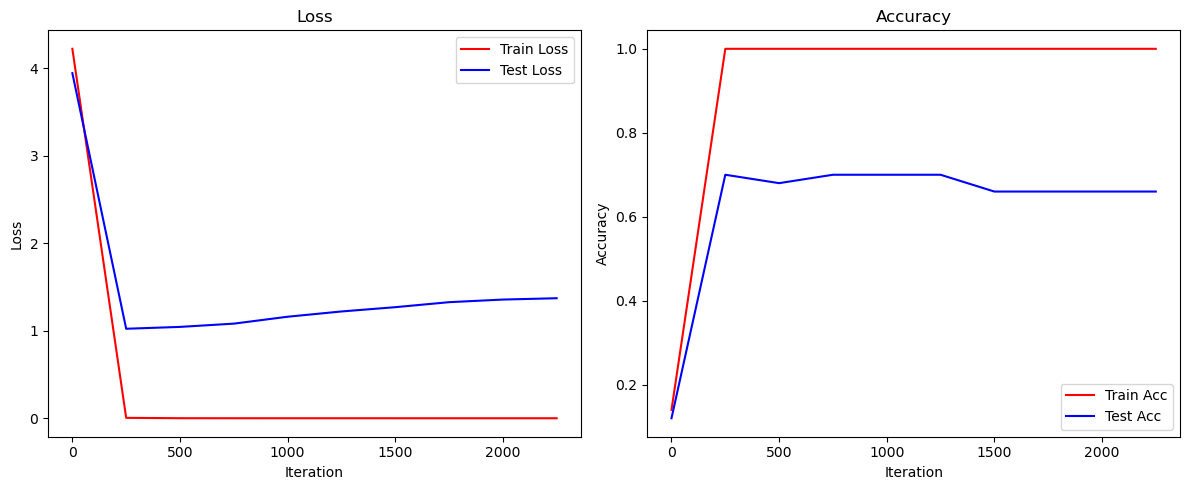

In [99]:
n_batch = 50
n_iter = 2500
n_prt = 250

sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_record_train = []
loss_record_test = []
acc_record_train = []
acc_record_test = []

for epoch in range(n_iter):
    idx = np.random.choice(train_x.shape[0], n_batch, replace=False)
    batch_x = train_x[idx]

    # train_y가 one-hot이면 그대로, 아니면 변환
    batch_y_raw = train_y[idx]
    if batch_y_raw.ndim == 2 and batch_y_raw.shape[1] == 10:
        batch_y = batch_y_raw
    else:
        batch_y = to_categorical(batch_y_raw, num_classes=10)

    # 학습 최적화
    sess.run(optm, feed_dict={x: batch_x, y: batch_y})

    if epoch % n_prt == 0:
        tidx = np.random.choice(test_x.shape[0], n_batch, replace=False)
        test_batch_x = test_x[tidx]

        test_batch_y_raw = test_y[tidx]
        if test_batch_y_raw.ndim == 2 and test_batch_y_raw.shape[1] == 10:
            test_batch_y = test_batch_y_raw
        else:
            test_batch_y = to_categorical(test_batch_y_raw, num_classes=10)

        # 손실 및 정확도 계산
        c1, a1 = sess.run([loss, accuracy], feed_dict={x: batch_x, y: batch_y})
        c2, a2 = sess.run([loss, accuracy], feed_dict={x: test_batch_x, y: test_batch_y})

        loss_record_train.append(c1)
        loss_record_test.append(c2)
        acc_record_train.append(a1)
        acc_record_test.append(a2)

        print(f"[{epoch}] Train Loss: {c1:.4f}, Acc: {a1:.4f} | Test Loss: {c2:.4f}, Acc: {a2:.4f}")

# 8. 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(loss_record_train)) * n_prt, loss_record_train, label="Train Loss", color='red')
plt.plot(np.arange(len(loss_record_test)) * n_prt, loss_record_test, label="Test Loss", color='blue')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(acc_record_train)) * n_prt, acc_record_train, label="Train Acc", color='red')
plt.plot(np.arange(len(acc_record_test)) * n_prt, acc_record_test, label="Test Acc", color='blue')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()